Station number: http://www.transitchicago.com/developers/ttdocs/default.aspx

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('cta-twitter-bot'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas
import baseball
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import pylab as pl
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns
# sns.set(style='white', context='notebook', font_scale=1.5)
sns.set(style='ticks', palette='Set2', context='notebook', font_scale=1.5, rc={'axes.edgecolor': 'gray'})

%matplotlib inline 

matplotlib.rcParams.update({'font.size': 8})

# Turns off that stupid Pandas warning about copying
pd.options.mode.chained_assignment = None  # default='warn'

In [57]:
cta_l_riders = pandas.read_csv("CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv")
cta_l_riders.index = cta_l_riders.date

# Addison Red line
station = cta_l_riders[(cta_l_riders.station_id==41420)]
# Addison Brown line
# station = cta_l_riders[(cta_l_riders.station_id==41440)]
# Sox-35th
# station = cta_l_riders[(cta_l_riders.station_id==40190)]
# Ashland Green/Pink line
# station = cta_l_riders[(cta_l_riders.station_id==40170)]

station.date = station.date.apply(lambda d: datetime.strptime(d, "%m/%d/%Y"))

station.insert(len(station.columns),'day_of_year', station['date'])
station.day_of_year = station.day_of_year.apply(lambda d: d.strftime('%j'))

station.insert(len(station.columns),'cubs_game', station['date'])
station.cubs_game = station.cubs_game.apply(lambda d: baseball.find_baseball_game('cubs',d))

station.insert(len(station.columns),'sox_game', station['date'])
station.sox_game = station.sox_game.apply(lambda d: baseball.find_baseball_game('sox',d))

station.insert(len(station.columns),'day_of_week', station['date'])
station.day_of_week = station.day_of_week.apply(lambda d: d.strftime('%w'))

ord_weather = pandas.read_csv('weather.csv')
ord_weather = ord_weather[ord_weather.STATION_NAME == "CHICAGO OHARE INTERNATIONAL AIRPORT IL US"]
ord_weather.DATE = ord_weather.DATE.apply(lambda d: datetime.strptime(str(d), "%Y%m%d"))
station = pd.merge(station,ord_weather,left_on='date', right_on='DATE')
station['TAVG'] = (station['TMAX'] + station['TMIN'])/2

station.daytype = station.daytype.apply(lambda d: 0 if d == "W" else d)
station.daytype = station.daytype.apply(lambda d: 1 if d == "A" else d)
station.daytype = station.daytype.apply(lambda d: 2 if d == "U" else d)
station.cubs_game = station.cubs_game.apply(lambda d: 0 if d == False else d)
station.cubs_game = station.cubs_game.apply(lambda d: 1 if d == True else d)


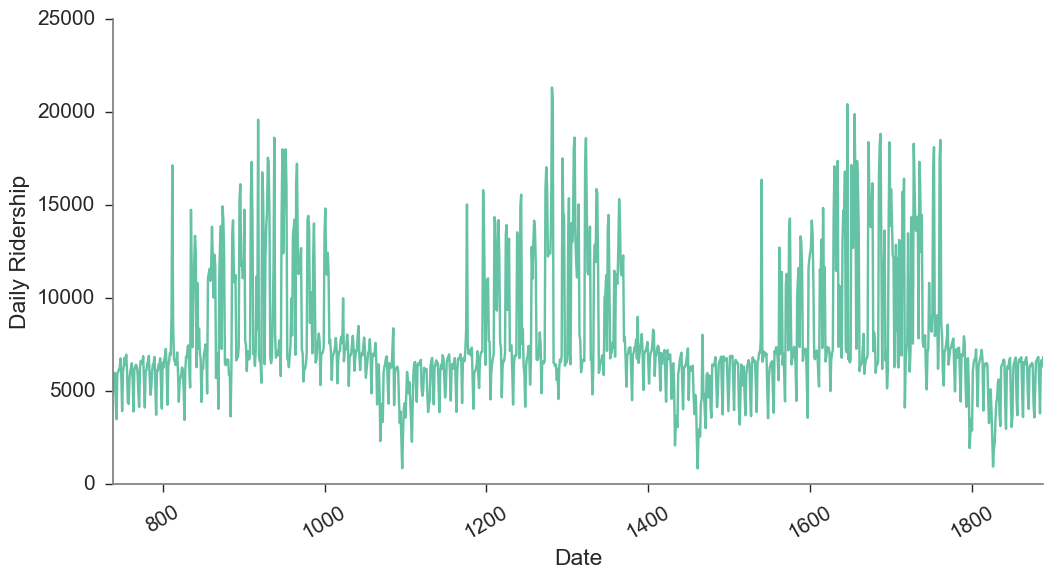

In [56]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
#matplotlib.rcParams.update({'font.size': 20})
months = mdates.MonthLocator()  # every month
years = mdates.YearLocator()   # every year


station[station.date > datetime.strptime("01/01/2013","%m/%d/%Y") ].rides.plot()


# format the ticks
#ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)


sns.despine()

plt.xticks(rotation=30)
# station[station.cubs_game==True]
plt.xlabel('Date')
plt.ylabel('Daily Ridership')

In [40]:
# features = ['day_of_year','day_of_week','cubs_game']

# features = ['day_of_year','day_of_week','cubs_game','TMAX','TMIN','PRCP']
features = ['day_of_year','day_of_week','cubs_game','TAVG']

features

['day_of_year', 'day_of_week', 'cubs_game', 'TAVG']

In [7]:
train, test = station[(station.date > datetime.strptime("01/01/2011","%m/%d/%Y")) & (station.date < datetime.strptime("01/01/2014","%m/%d/%Y")) ], station[station.date >=datetime.strptime("01/01/2014","%m/%d/%Y")]

In [58]:
rf = RandomForestRegressor(n_estimators=800, n_jobs=2, min_samples_leaf=5,max_depth=50)
# rf = AdaBoostRegressor(DecisionTreeRegressor(min_samples_leaf=10), n_estimators=300)
rf.fit(train[features], train.rides)
rf.feature_importances_

array([ 0.16655138,  0.08881911,  0.59930704,  0.14532246])

In [47]:
rf.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [59]:
r2 = r2_score(test.rides, rf.predict(test[features]))
mse = np.mean((test.rides - rf.predict(test[features]))**2)
# rf.predict(test[features])
print(r2)

0.695809811865


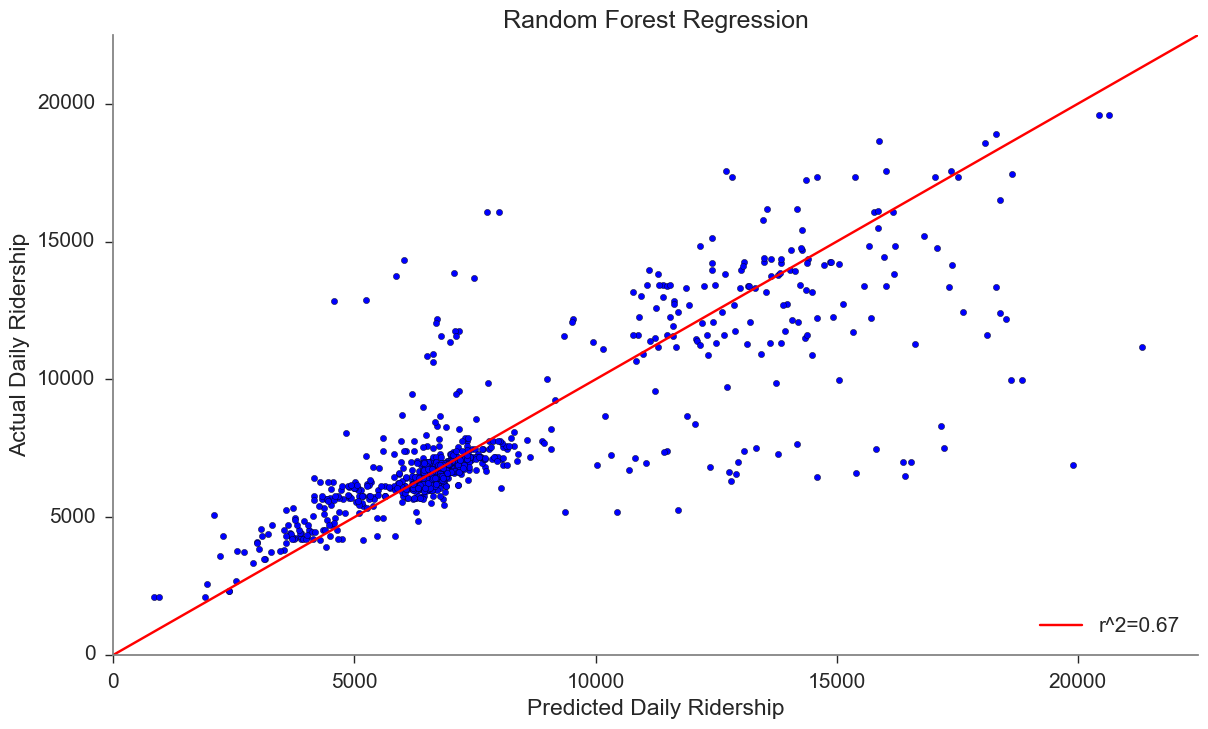

In [14]:
pl.figure(figsize=(14, 8))

# fig, ax = plt.subplots()
# ax.tick_params(color='gray')
# ax.stackplot(x, y)
# plt.show()

pl.xlim([0,22500])
pl.ylim([0,22500])
pl.scatter(test.rides, rf.predict(test[features]))
matplotlib.rcParams.update({'font.size': 25})
pl.plot(np.arange(0, 22500), np.arange(0, 22500), label="r^2=" + str(round(r2,2)), c="r")
pl.legend(loc="lower right")
pl.title("Random Forest Regression")
plt.xlabel('Predicted Daily Ridership')
plt.ylabel('Actual Daily Ridership')
sns.despine()
pl.savefig('rf_regression.png',dpi=100)
pl.show()

## Try GridSearchCV

In [44]:
parameters = [{'n_estimators':[100],'min_samples_leaf':[1,5,10,20],'max_depth':[20,30,40,50]}]
clf = GridSearchCV(RandomForestRegressor(n_jobs=2),parameters)
clf.fit(train[features], train.rides)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [20, 30, 40, 50], 'n_estimators': [100], 'min_samples_leaf': [1, 5, 10, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [45]:
clf.best_params_

{'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 100}